#### 2019 2nd ML month with KaKR

- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.

- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.

- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.

- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


In [14]:
data_dir = os.getcwd()+'/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [15]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


date 전처리

In [16]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


타겟 데이터에 해당하는 price 칼럼 삭제
y 변수에 price 넣어두고 train에서는 삭제

In [17]:
y=train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


test 데이터에 대해서도 같은 작업 진행 

In [18]:
test['date']=test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [19]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

가격 데이터의 분포 확인

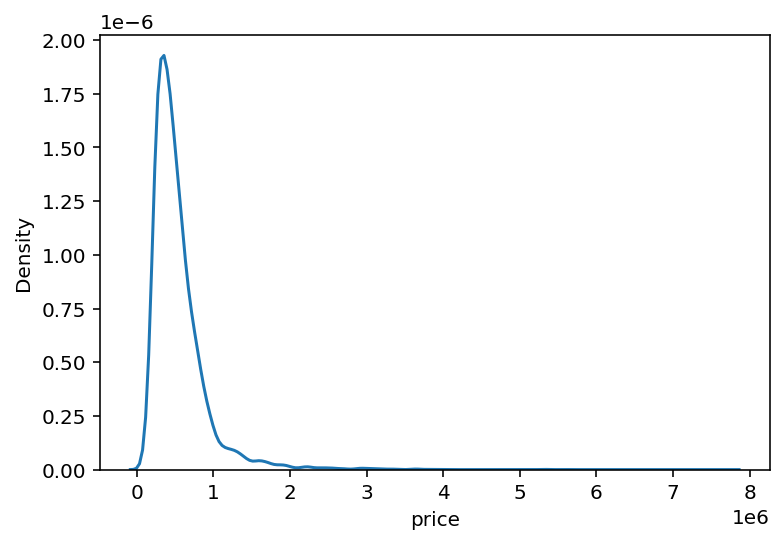

In [20]:
sns.kdeplot(y)
plt.show()

치우쳐 있는 함수, 분포를 위해 y는 np.log1p 함수를 통해 로그 변환, 모델이 값 예측 후 다시 np.expm1을 활용해서 되돌림

In [22]:
y=np.log1p(y)
y

0        2.588515
1        2.572667
2        2.649161
3        2.599632
4        2.608893
           ...   
15030    2.661820
15031    2.696179
15032    2.624224
15033    2.631833
15034    2.616781
Name: price, Length: 15035, dtype: float64

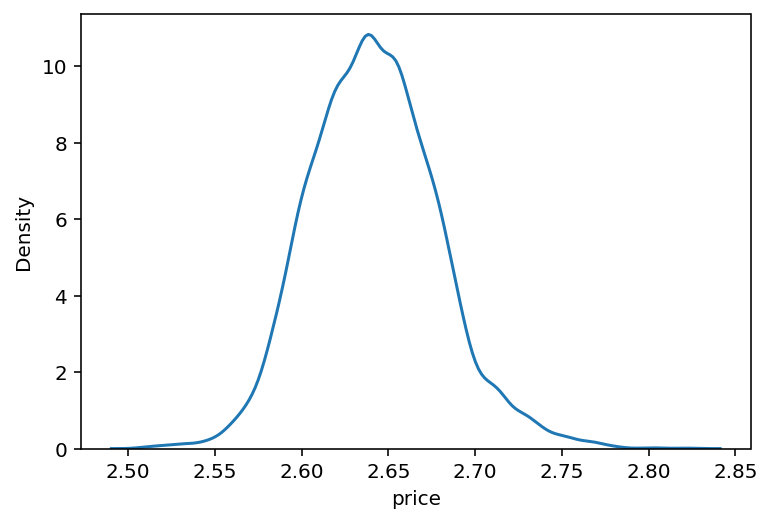

In [23]:
sns.kdeplot(y)
plt.show()

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int32  
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('diq')

diq


대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.
한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

In [26]:
def rmse(y_test,y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))

print('얍')

얍


In [42]:
#모델 가져오기

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [43]:
#모델 인스턴스 생성 후 models 리스트에 넣어줌
#randdom_state 값 고정 

random_state=2020

gboost=GradientBoostingRegressor(random_state=random_state)
xgboost=XGBRegressor(random_state=random_state)
lightgbm=LGBMRegressor(random_state=random_state)
rdforest=RandomForestRegressor(random_state=random_state)

models=[gboost,xgboost,lightgbm,rdforest]

print('얍')

얍


random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현됩니다. 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라집니다.

In [44]:
#각 모델 이름은 클래스의 name속성에 접근해 알 수 있음
gboost.__class__.__name__

'GradientBoostingRegressor'

모델 별로 학습 및 예측

In [45]:
df={}

for model in models:
    #모델 이름 획득
    model_name=model.__class__.__name__
    
    #train, test 데이터셋분리 - 여기도 random_state 고정
    X_train,X_test,y_train,y_test=train_test_split(train,y,random_state=random_state)
    
    #모델 학습
    model.fit(X_train,y_train)
    
    #예측
    y_pred=model.predict(X_test)
    
    #예측 결과의 rmse 값 저장
    df[model_name]=rmse(y_test,y_pred)
    
    #data frame에 저장
    score_df=pd.DataFrame(df,index=['RMSE']).T.sort_values('RMSE',ascending=False)
    
    
df

{'GradientBoostingRegressor': 0.18437695950455352,
 'XGBRegressor': 0.17096667588951747,
 'LGBMRegressor': 0.16502525939296728,
 'RandomForestRegressor': 0.17977069977396343}

In [46]:
#get_score 함수

def get_scores(models,train,y):
    de={}
    
    for model in models:
        model_name=model.__class__.__name__
        
        X_train,X_test,y_train,y_test=train_test_split(train,y,random_state=random_state,test_size=0.2)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        
        df[model_name]=rmse(y_test,y_pred)
        score_df=pd.DataFrame(df,index=['RMSE']).T.sort_values('RMSE',ascending=False)
        
    
    return score_df

### 하이퍼 파라미터 튜닝, 그리드 탐색
하이퍼 파리미터로 실험

In [47]:
from sklearn.model_selection import GridSearchCV

print('dd')

dd


#### GridSearchCV

- 그리드 탐색: 하이터 파라미터 값 사람이 지정, 그 값들로 만들어질 수 있는 모든 조합 탐색

- 랜덤 탐색: 사람이 탐색할 하이터 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합 선택

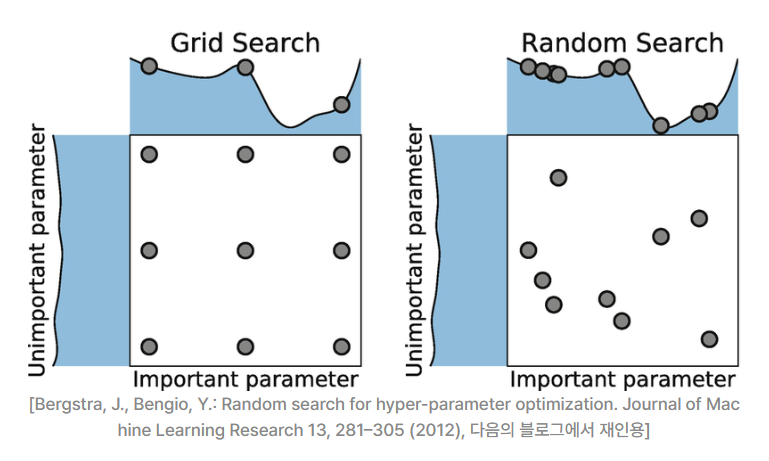

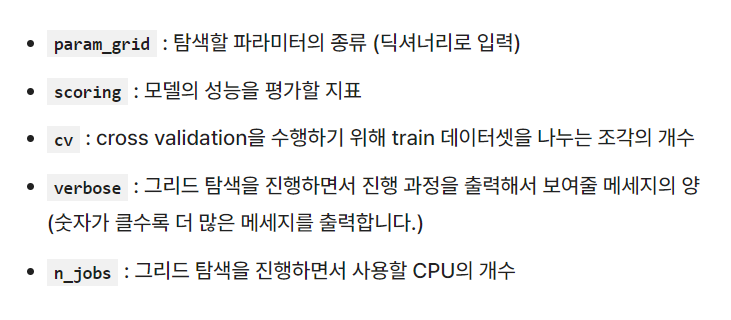

In [48]:
# param_grod에 xgboost 관련 하이퍼 파라미터
param_grid={
    'n_estimators':[50,100],
    'max_depth':[1,10],
}

In [49]:
#모델 준비
model=LGBMRegressor(random_state=random_state)

print('얍')

얍


GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [72]:

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=1)

grid_model.fit(train,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   19.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [74]:
#실험에 대한 결과
grid_model.cv_results_

{'mean_fit_time': array([0.26891985, 0.42237849, 0.86219869, 2.12546406]),
 'std_fit_time': array([0.10927519, 0.16036793, 0.31481923, 1.55952695]),
 'mean_score_time': array([0.014961  , 0.0567596 , 0.03320088, 0.04474545]),
 'std_score_time': array([0.00302615, 0.04033693, 0.01086483, 0.00923579]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.00037839, -0.00027917, -0.00014792, -0.00013892]),
 'split1_test_score': array([-0.00038423, -0.00029197, -0.00015702, -0.00014509]),
 'split2_test_score': array([-0.00037037

어떤 파라미터 조합일 떄 점수가 어떻게 나오는지 
파라미터 조합은 params 딕셔너리, 각각의 테스트 점수는 mean_test_score에 저장

In [73]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [76]:
score=grid_model.cv_results_['mean_test_score']
score

array([-0.00036765, -0.00027737, -0.00015088, -0.0001407 ])

In [77]:
results=pd.DataFrame(params)
results['score']=score

results

,max_depth,n_estimators,score
0,1,50,-0.000368
1,1,100,-0.000277
2,10,50,-0.000151
3,10,100,-0.000141


왜 점수는 음수일까?

gridsearchcv로 grid 모델 초기화 할 떄 scoring 인자에 mse에 음수를 취한 값이 neg_mean_squared_error 입력

scoring 범주
Classification, Clustering, Regression이다. 어떤 문제를 푸느냐에 따라 각 상황에 알맞은 점수 체계를 사용할 수 있다.

In [87]:
#rmse 점수 볼 수 있게
results['RMSE']=np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSEL,RMSE
0,1,50,-0.000368,0.019174,0.019174
1,1,100,-0.000277,0.016655,0.016655
2,10,50,-0.000151,0.012284,0.012284
3,10,100,-0.000141,0.011862,0.011862


In [88]:
#사실은 위 값이 log를 취한 값에서 rmse를 구한것

results=results.rename(columns={'RMSE':'RMSLE'})
results

,max_depth,n_estimators,score,RMSEL,RMSLE
0,1,50,-0.000368,0.019174,0.019174
1,1,100,-0.000277,0.016655,0.016655
2,10,50,-0.000151,0.012284,0.012284
3,10,100,-0.000141,0.011862,0.011862


In [89]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.

results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSEL,RMSLE
3,10,100,-0.000141,0.011862,0.011862
2,10,50,-0.000151,0.012284,0.012284
1,1,100,-0.000277,0.016655,0.016655
0,1,50,-0.000368,0.019174,0.019174


In [91]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 제출함수

In [96]:
param_grid={
    'n_estimators':[50,100],
    'max_depth':[1,10],
}

model=LGBMRegressor(random_state=random_state)
my_GridSearch(model,train,y,param_grid,verbose=2,n_jobs=None)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... max_depth=1, n_estimators=50, total=   0.5s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.2s
[CV] max_depth=1, n_estimators=50 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ..................... max_depth=1, n_estimators=50, total=   0.2s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.2s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.6s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.5s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.3s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   12.7s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.000141,0.011862
2,10,50,-0.000151,0.012284
1,1,100,-0.000277,0.016655
0,1,50,-0.000368,0.019174
